In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
!pip install linearmodels
from linearmodels import PanelOLS
import matplotlib.pyplot as plt
from linearmodels import RandomEffects
from scipy.stats.mstats import winsorize
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## **Data ingestion**

In [ ]:
chunk_size = 100000
filtered_chunks = []

for chunk in pd.read_csv("/content/Gravity_V202211.csv", chunksize=chunk_size, low_memory=False ):
    chunk_filtered = chunk[chunk["year"] >= 2000]
    filtered_chunks.append(chunk_filtered)

df = pd.concat(filtered_chunks, ignore_index=True)
df.head()

,year,country_id_o,country_id_d,iso3_o,iso3_d,iso3num_o,iso3num_d,country_exists_o,country_exists_d,gmt_offset_2020_o,...,entry_time_o,entry_time_d,entry_tp_o,entry_tp_d,tradeflow_comtrade_o,tradeflow_comtrade_d,tradeflow_baci,manuf_tradeflow_baci,tradeflow_imf_o,tradeflow_imf_d
0,2000,ABW,ABW,ABW,ABW,533.0,533.0,1,1,-4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,ABW,ABW,ABW,ABW,533.0,533.0,1,1,-4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002,ABW,ABW,ABW,ABW,533.0,533.0,1,1,-4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003,ABW,ABW,ABW,ABW,533.0,533.0,1,1,-4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004,ABW,ABW,ABW,ABW,533.0,533.0,1,1,-4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Panel OLS**

In [ ]:
gravity = df.copy()

relevant_columns = [
    "year", "iso3_o", "iso3_d", "dist", "contig", "comlang_off",
    "gdp_o", "gdp_d", "pop_o", "pop_d", "fta_wto", "rta_coverage",
    "rta_type", "tradeflow_baci", "tradeflow_comtrade_o",
    "tradeflow_comtrade_d", "tradeflow_imf_o", "tradeflow_imf_d",
    "comcol", "comleg_pretrans", "comleg_posttrans", "comrelig"]

gravity = gravity[relevant_columns].copy()
gravity = gravity.rename(columns={
    "iso3_o": "exporter",
    "iso3_d": "importer",
    "gdp_o": "gdp_exporter",
    "gdp_d": "gdp_importer",
    "pop_o": "pop_exporter",
    "pop_d": "pop_importer",
    "fta_wto": "trade_agreement",
    "tradeflow_baci": "trade_value"})

gravity = gravity.drop(columns=["rta_coverage", "rta_type",
                              "tradeflow_comtrade_o", "tradeflow_comtrade_d",
                              "tradeflow_imf_o", "tradeflow_imf_d"])
gravity = gravity.dropna(subset=["trade_value"]).copy()

numerical_cols = ["gdp_exporter", "gdp_importer", "pop_exporter", "pop_importer"]
for col in numerical_cols:
    gravity.loc[:, col] = gravity[col].fillna(gravity[col].median())

categorical_cols = ["comlang_off", "comcol", "comleg_pretrans", "comleg_posttrans", "comrelig"]
for col in categorical_cols:
    gravity.loc[:, col] = gravity[col].fillna(gravity[col].mode()[0])

gravity = gravity.dropna().copy()

brics_countries = ["BRA", "RUS", "IND", "CHN", "ZAF"]
gravity_emerging = gravity[
    (gravity["exporter"].isin(brics_countries)) |
    (gravity["importer"].isin(brics_countries))].copy()

gravity_emerging.loc[:, "ln_trade_value"] = np.log(gravity_emerging["trade_value"])
gravity_emerging.loc[:, "ln_gdp_importer"] = np.log(gravity_emerging["gdp_importer"])
gravity_emerging.loc[:, "ln_gdp_exporter"] = np.log(gravity_emerging["gdp_exporter"])
gravity_emerging.loc[:, "ln_distance"] = np.log(gravity_emerging["dist"])
gravity_emerging.loc[:, "trade_agreement"] = gravity_emerging["trade_agreement"].astype(int)

gravity_emerging.loc[:, "ln_gdp_diff"] = abs(gravity_emerging["ln_gdp_importer"] - gravity_emerging["ln_gdp_exporter"])
gravity_emerging = gravity_emerging.sort_values(['exporter', 'importer', 'year']).copy()
gravity_emerging.loc[:, 'gdp_growth_exporter'] = gravity_emerging.groupby(['exporter', 'importer'])['ln_gdp_exporter'].pct_change()
gravity_emerging.loc[:, 'gdp_growth_importer'] = gravity_emerging.groupby(['exporter', 'importer'])['ln_gdp_importer'].pct_change()

def calculate_mrt(data):
    """Calculates MRTs using the method described by Anderson & van Wincoop (2003)."""
    data_mrt = data.copy()
    data_mrt.loc[:, 'total_trade_importer'] = data_mrt.groupby(['importer', 'year'])['trade_value'].transform('sum')
    data_mrt.loc[:, 'total_trade_exporter'] = data_mrt.groupby(['exporter', 'year'])['trade_value'].transform('sum')

    data_mrt.loc[:, 'mrt_importer'] = data_mrt['total_trade_importer'] / data_mrt.groupby('importer')['trade_value'].transform('sum')
    data_mrt.loc[:, 'mrt_exporter'] = data_mrt['total_trade_exporter'] / data_mrt.groupby('exporter')['trade_value'].transform('sum')

    data_mrt.loc[:, 'ln_mrt_importer'] = np.log(data_mrt['mrt_importer'])
    data_mrt.loc[:, 'ln_mrt_exporter'] = np.log(data_mrt['mrt_exporter'])

    return data_mrt

gravity_emerging = calculate_mrt(gravity_emerging)

gravity_emerging.loc[:, 'ln_trade_value_lagged'] = gravity_emerging.groupby(['exporter', 'importer'])['ln_trade_value'].shift(1)
gravity_emerging = gravity_emerging.dropna().copy()

# additional variables
gravity_emerging.loc[:, 'ln_gdp_product'] = gravity_emerging['ln_gdp_importer'] + gravity_emerging['ln_gdp_exporter']

required_columns = ['exporter', 'year', 'ln_gdp_product']
if all(col in gravity_emerging.columns for col in required_columns):
    gravity_emerging = gravity_emerging.set_index(['exporter', 'year'])
else:
    missing = [col for col in required_columns if col not in gravity_emerging.columns]
    raise ValueError(f"Missing required columns: {missing}")

for var in ['ln_distance', 'ln_mrt_importer', 'ln_gdp_product']:
    if var in gravity_emerging.columns:
        gravity_emerging.loc[:, f'{var}_c'] = gravity_emerging[var] - gravity_emerging[var].mean()
    else:
        raise ValueError(f"Column {var} not found in DataFrame")

gravity_emerging['BRICS_pair'] = (
    gravity_emerging.index.get_level_values('exporter').isin(['BRA','RUS','IND','CHN','ZAF']) &  # Accessing exporter from index
    gravity_emerging['importer'].isin(['BRA','RUS','IND','CHN','ZAF'])
).astype(int)
gravity_emerging['Post2008'] = (gravity_emerging.index.get_level_values('year') >= 2008).astype(int)  # Accessing year from index
gravity_emerging['BRICS_post2008'] = gravity_emerging['BRICS_pair'] * gravity_emerging['Post2008']
gravity_emerging['BRICS_RTA'] = gravity_emerging['BRICS_post2008'] * gravity_emerging['trade_agreement']
# interaction terms
gravity_emerging.loc[:, 'dist_RTA'] = gravity_emerging['ln_distance_c'] * gravity_emerging['trade_agreement']
gravity_emerging.loc[:, 'mrt_RTA'] = gravity_emerging['ln_mrt_importer_c'] * gravity_emerging['trade_agreement']
gravity_emerging.loc[:, 'gdp_trade_agreement_interaction'] = gravity_emerging['ln_gdp_product_c'] * gravity_emerging['trade_agreement']

gravity_emerging["gdp_distance_interaction"] = gravity_emerging["ln_gdp_product_c"] * gravity_emerging["ln_distance_c"]
gravity_emerging.loc[:, 'ln_distance_c_sq'] = gravity_emerging['ln_distance_c'] ** 2

gravity_emerging["gdp_mrt_importer_interaction"] = gravity_emerging["ln_gdp_product_c"] * gravity_emerging["ln_mrt_importer_c"]
gravity_emerging["gdp_rta_interaction"] = gravity_emerging["ln_gdp_product_c"] * gravity_emerging["trade_agreement"]
gravity_emerging["ln_gdp_product_sq"] = gravity_emerging["ln_gdp_product_c"] ** 2
gravity_emerging["ln_mrt_exporter_c"] = gravity_emerging["ln_mrt_exporter"] - gravity_emerging["ln_mrt_exporter"].mean()
gravity_emerging["gdp_mrt_exporter_interaction"] = gravity_emerging["ln_gdp_product_c"] * gravity_emerging["ln_mrt_exporter_c"]
gravity_emerging["mrt_interaction"] = gravity_emerging["ln_mrt_importer_c"] * gravity_emerging["ln_mrt_exporter_c"]

gravity_emerging["distance_trade_agreement_interaction"] = gravity_emerging["ln_distance"] * gravity_emerging["trade_agreement"]
gravity_emerging["mrt_trade_agreement_interaction"] = gravity_emerging["ln_mrt_importer"] * gravity_emerging["trade_agreement"]


In [ ]:
X_columns = [
    'ln_gdp_product_c',
    'ln_distance_c',
    'trade_agreement',
    'comlang_off',
    'contig',
    'ln_trade_value_lagged',
    'ln_mrt_importer_c',
    'ln_mrt_exporter_c',
    'ln_gdp_diff',
    'gdp_growth_importer',
    'gdp_growth_exporter',
    'dist_RTA',
    'mrt_RTA',
    'gdp_trade_agreement_interaction',
    'BRICS_RTA',
    'BRICS_post2008',
    'gdp_distance_interaction',
    'gdp_mrt_importer_interaction',
    'gdp_rta_interaction',
    'ln_gdp_product_sq',
    'mrt_interaction',
    'ln_distance_c_sq',
    'mrt_trade_agreement_interaction',
    'distance_trade_agreement_interaction']

missing_X = [col for col in X_columns if col not in gravity_emerging.columns]
if missing_X:
    raise ValueError(f"Missing columns in X: {missing_X}")

X = gravity_emerging[X_columns].copy()

In [ ]:
X_columns = [
    'ln_gdp_product_c',
    'ln_distance_c',
    'trade_agreement',
    'comlang_off',
    'contig',
    'ln_trade_value_lagged',
    'ln_mrt_importer_c',
    'ln_mrt_exporter_c',
    'ln_gdp_diff',
    'gdp_growth_importer',
    'gdp_growth_exporter',
    'dist_RTA',
    'mrt_RTA',
    'gdp_trade_agreement_interaction',
    'BRICS_RTA',
    'BRICS_post2008',
    'gdp_distance_interaction',
    'gdp_mrt_importer_interaction',
    'gdp_rta_interaction',
    'ln_gdp_product_sq',
    'mrt_interaction',
    'ln_distance_c_sq',
    'mrt_trade_agreement_interaction',
    'distance_trade_agreement_interaction']

missing_X = [col for col in X_columns if col not in gravity_emerging.columns]
if missing_X:
    raise ValueError(f"Missing columns in X: {missing_X}")

X = gravity_emerging[X_columns].copy()
X = sm.add_constant(X)
y = gravity_emerging["ln_trade_value"]

if not X.index.equals(y.index):
    X, y = X.align(y, axis=0, join='inner')

model = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,
    time_effects=True,
    check_rank=False,
    drop_absorbed=True)

results = model.fit(cov_type="clustered", cluster_entity=True)
print(results.summary)

<ipython-input-5-afcfc1ae6e0c>:56: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

BRICS_RTA, gdp_rta_interaction, mrt_trade_agreement_interaction, distance_trade_agreement_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.8072
Estimator:                   PanelOLS   R-squared (Between):              0.9762
No. Observations:               40706   R-squared (Within):               0.7886
Date:                Tue, Apr 08 2025   R-squared (Overall):              0.8820
Time:                        14:15:43   Log-likelihood                -6.848e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8466.3
Entities:                         227   P-value                           0.0000
Avg Obs:                       179.32   Distribution:                F(20,40440)
Min Obs:                      10.0000                                           
Max Obs:                       4308.0   F-statistic (robust):             7606.9
                            

## **Marginal Effect of Trade Agreements by GDP Size**

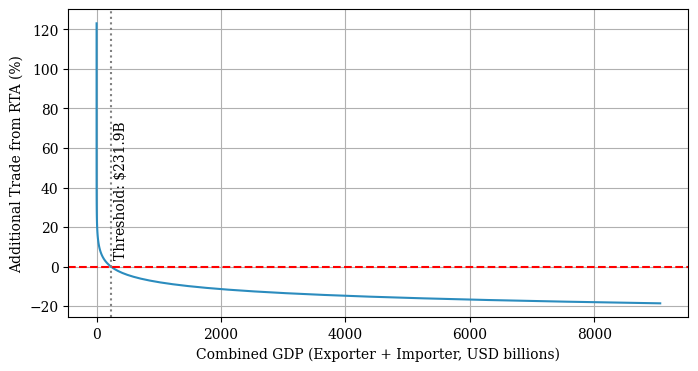

In [ ]:
gdp_grid = np.linspace(gravity_emerging['ln_gdp_product_c'].min(),
                       gravity_emerging['ln_gdp_product_c'].max(),
                       100)

marginal_effects = 0.305 + (-0.056 * gdp_grid)
marginal_effects_pct = (np.exp(marginal_effects) - 1) * 100

plt.figure(figsize=(8,4))
plt.plot(np.exp(gdp_grid), marginal_effects_pct, color='#2b8cbe')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Combined GDP (Exporter + Importer, USD billions)')
plt.ylabel('Additional Trade from RTA (%)')
plt.grid()

threshold = np.exp((0.305/abs(-0.056)))
plt.axvline(x=threshold, color='grey', linestyle=':')
plt.text(threshold+50, 5, f'Threshold: ${threshold:.1f}B', rotation=90)
plt.show()

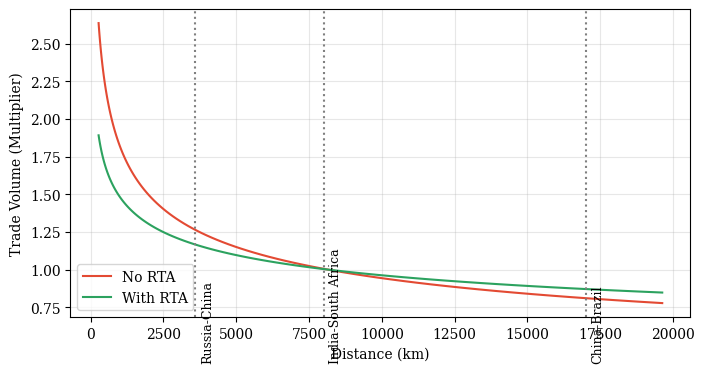

In [ ]:
dist_grid = np.linspace(gravity_emerging['ln_distance_c'].min(),
                        gravity_emerging['ln_distance_c'].max(),
                        100)

base_distance_penalty = -0.286 * dist_grid
rta_distance_penalty = (-0.286 + 0.098) * dist_grid

distance_km = np.exp(dist_grid + gravity_emerging['ln_distance'].mean())
base_effect = np.exp(base_distance_penalty)
rta_effect = np.exp(rta_distance_penalty)

plt.figure(figsize=(8,4))
plt.plot(distance_km, base_effect, color='#e34a33', label='No RTA')
plt.plot(distance_km, rta_effect, color='#2ca25f', label='With RTA')
plt.title('Distance Decay: RTA Mitigation Effect')
plt.xlabel('Distance (km)')
plt.ylabel('Trade Volume (Multiplier)')
plt.legend()
plt.grid(True, alpha=0.3)

brics_distances = {
    'China-Brazil': 17000,
    'India-South Africa': 8000,
    'Russia-China': 3600}
for pair, dist in brics_distances.items():
    plt.axvline(x=dist, color='grey', linestyle=':')
    plt.text(dist+200, 0.4, pair, rotation=90, fontsize=9)

plt.show()

## **Heatmap**

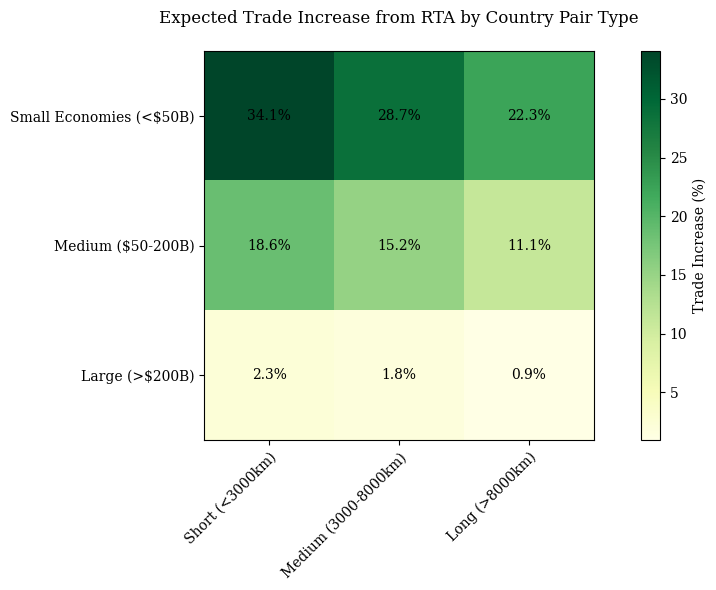

In [ ]:
gdp_levels = ['Small Economies (<$50B)', 'Medium ($50-200B)', 'Large (>$200B)']
distance_levels = ['Short (<3000km)', 'Medium (3000-8000km)', 'Long (>8000km)']
effect_matrix = np.array([
    [34.1, 28.7, 22.3],
    [18.6, 15.2, 11.1],
    [2.3, 1.8, 0.9] ])

fig, ax = plt.subplots(figsize=(10,6))
im = ax.imshow(effect_matrix, cmap='YlGn')

ax.set_xticks(np.arange(len(distance_levels)))
ax.set_yticks(np.arange(len(gdp_levels)))
ax.set_xticklabels(distance_levels)
ax.set_yticklabels(gdp_levels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(gdp_levels)):
    for j in range(len(distance_levels)):
        ax.text(j, i, f"{effect_matrix[i,j]:.1f}%",
                ha="center", va="center", color="black")

ax.set_title("Expected Trade Increase from RTA by Country Pair Type", pad=20)
fig.colorbar(im, label='Trade Increase (%)')
plt.tight_layout()
plt.show()

In [ ]:
gravity_emerging['gdp_exporter_dist_interaction'] = \
gravity_emerging['ln_gdp_exporter_c'] * gravity_emerging['ln_distance_c']
gravity_emerging['gdp_importer_dist_interaction'] = \
gravity_emerging['ln_gdp_importer_c'] * gravity_emerging['ln_distance_c']
gravity_emerging['gdp_exporter_rta_interaction'] = \
gravity_emerging['ln_gdp_exporter_c'] * gravity_emerging['trade_agreement']
gravity_emerging['gdp_importer_rta_interaction'] = \
gravity_emerging['ln_gdp_importer_c'] * gravity_emerging['trade_agreement']

X_columns = [
    'ln_gdp_exporter_c', 'ln_gdp_importer_c',  # Separate GDP terms
    'ln_distance_c', 'trade_agreement',
    'comlang_off', 'contig', 'ln_trade_value_lagged',
    'ln_mrt_importer_c', 'ln_mrt_exporter_c',
    'ln_gdp_diff', 'gdp_growth_importer', 'gdp_growth_exporter',
    'gdp_exporter_dist_interaction', 'gdp_importer_dist_interaction',  # New interactions
    'gdp_exporter_rta_interaction', 'gdp_importer_rta_interaction',  # New interactions
    'BRICS_RTA', 'BRICS_post2008',
    'ln_distance_c_sq', 'mrt_interaction']

X = gravity_emerging[X_columns].copy()
X = sm.add_constant(X)
y = gravity_emerging["ln_trade_value"]

if not X.index.equals(y.index):
    X, y = X.align(y, axis=0, join='inner')

model = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,
    time_effects=True,
    check_rank=False,
    drop_absorbed=True)

results = model.fit(cov_type="clustered", cluster_entity=True)
print(results.summary)

<ipython-input-13-720b241b1663>:37: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

BRICS_RTA

  results = model.fit(cov_type="clustered", cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.8079
Estimator:                   PanelOLS   R-squared (Between):              0.9118
No. Observations:               40706   R-squared (Within):               0.7990
Date:                Tue, Apr 01 2025   R-squared (Overall):              0.8466
Time:                        05:44:50   Log-likelihood                -6.841e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8950.7
Entities:                         227   P-value                           0.0000
Avg Obs:                       179.32   Distribution:                F(19,40441)
Min Obs:                      10.0000                                           
Max Obs:                       4308.0   F-statistic (robust):          1.757e+04
                            

In [ ]:
# Test H₉: β_importer = β_exporter
wald_test = results.wald_test(formula="ln_gdp_importer_c - ln_gdp_exporter_c = 0")
print(wald_test)

Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 29.7344
P-value: 0.0000
Distributed: chi2(1)


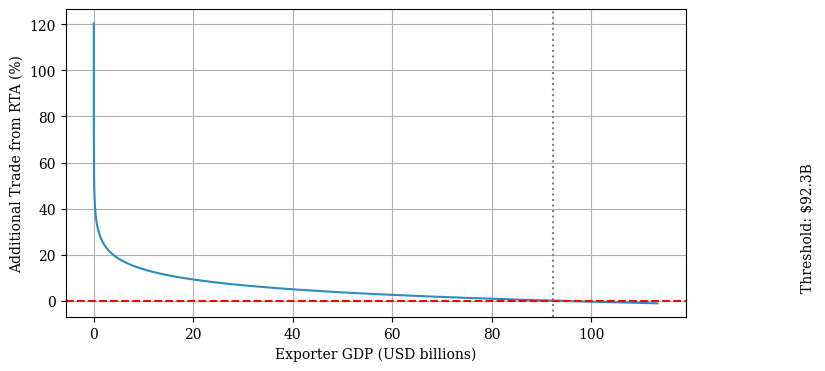

In [ ]:
dp_grid = np.linspace(gravity_emerging['ln_gdp_exporter_c'].min(),
                       gravity_emerging['ln_gdp_exporter_c'].max(),
                       100)

# coefficients from the results (replace 'trade_agreement' and interaction term)
trade_agreement_coeff = results.params['trade_agreement']
interaction_coeff = results.params['gdp_exporter_rta_interaction']

marginal_effects = trade_agreement_coeff + (interaction_coeff * dp_grid)
marginal_effects_pct = (np.exp(marginal_effects) - 1) * 100

plt.figure(figsize=(8, 4))
plt.plot(np.exp(dp_grid), marginal_effects_pct, color='#2b8cbe')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Exporter GDP (USD billions)')
plt.ylabel('Additional Trade from RTA (%)')
plt.grid()

threshold = -trade_agreement_coeff / interaction_coeff
plt.axvline(x=np.exp(threshold), color='grey', linestyle=':')
plt.text(np.exp(threshold) + 50, 5, f'Threshold: ${np.exp(threshold):.1f}B', rotation=90)

plt.show()

## **Threshold model: threshold variable (GDP asymmetry)**

<ipython-input-47-3b6345dedc94>:56: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gdp_rta_interaction, BRICS_RTA

  model_below = PanelOLS(y_below, X_below, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True).fit()
<ipython-input-47-3b6345dedc94>:57: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gdp_rta_interaction, BRICS_RTA

  model_above = PanelOLS(y_above, X_above, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True).fit()
<ipython-input-47-3b6345dedc94>:56: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gdp_rta_interaction, BRICS_RTA

  model_below = PanelOLS(y_below, X_below, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True).fit()
<ipython-input-47-3b6345dedc94>:57: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from 

Optimal Threshold: 5.653364951489646


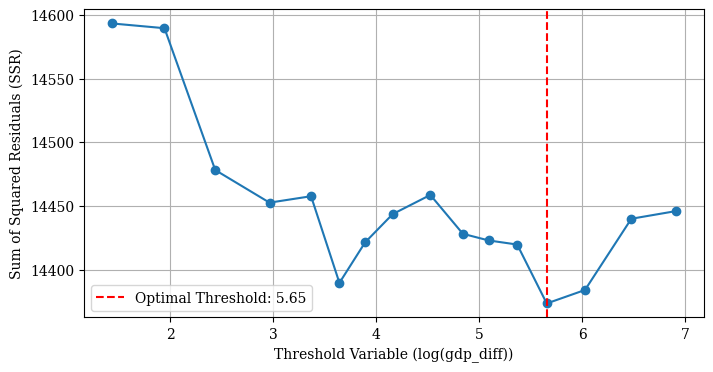

In [ ]:
gravity_emerging["ln_gdp_diff"] = np.abs(gravity_emerging["ln_gdp_importer"] - gravity_emerging["ln_gdp_exporter"])
threshold_var = gravity_emerging["ln_gdp_diff"]

X_columns = [
    'ln_gdp_product_c',
    'ln_distance_c',
    'trade_agreement',
    'comlang_off',
    'contig',
    'ln_trade_value_lagged',
    'ln_mrt_importer_c',
    'ln_mrt_exporter_c',
    'ln_gdp_diff',
    'gdp_growth_importer',
    'gdp_growth_exporter',
    'dist_RTA',
    'mrt_RTA',
    'gdp_trade_agreement_interaction',
    'BRICS_RTA',
    'BRICS_post2008',
    'gdp_distance_interaction',
    'gdp_mrt_importer_interaction',
    'gdp_rta_interaction',
    'ln_gdp_product_sq',
    'mrt_interaction',
    'ln_distance_c_sq']

y = gravity_emerging[["ln_trade_value"]]

X = gravity_emerging[X_columns].set_index([gravity_emerging.index.get_level_values(0),
                                           gravity_emerging.index.get_level_values(1)])
y = y.set_index([gravity_emerging.index.get_level_values(0),
                 gravity_emerging.index.get_level_values(1)])

grid_thresholds = np.percentile(threshold_var, np.arange(10, 90, 5))

ssr_values = []

for gamma in grid_thresholds:
    below_threshold = threshold_var <= gamma
    above_threshold = threshold_var > gamma

    X_below = sm.add_constant(gravity_emerging.loc[below_threshold, X_columns])
    y_below = gravity_emerging.loc[below_threshold, "ln_trade_value"]

    X_above = sm.add_constant(gravity_emerging.loc[above_threshold, X_columns])
    y_above = gravity_emerging.loc[above_threshold, "ln_trade_value"]

    model_below = PanelOLS(y_below, X_below, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True).fit()
    model_above = PanelOLS(y_above, X_above, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True).fit()

    ssr = np.sum(model_below.resids**2) + np.sum(model_above.resids**2)  # Changed this line
    ssr_values.append(ssr)

optimal_gamma = grid_thresholds[np.argmin(ssr_values)]
print(f"Optimal Threshold: {optimal_gamma}")

plt.figure(figsize=(8, 4))
plt.plot(grid_thresholds, ssr_values, marker='o', linestyle='-')
plt.axvline(optimal_gamma, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_gamma:.2f}')
plt.xlabel("Threshold Variable (log(gdp_diff))")
plt.ylabel("Sum of Squared Residuals (SSR)")
plt.title("Threshold Selection - Sum of Squared Residuals")
plt.legend()
plt.grid()
plt.show()

## **Robustness check by region**

In [ ]:
!pip install country_converter

In [ ]:
import country_converter as coco

importer_countries = gravity_emerging["importer"].unique()
country_to_region_dict = coco.convert(names=importer_countries, to='UNRegion', not_found=None)
country_to_region_dict = dict(zip(importer_countries, country_to_region_dict))

gravity_emerging["region"] = gravity_emerging["importer"].map(country_to_region_dict)

if gravity_emerging["region"].isnull().sum() > 0:
    print("Warning: Some countries have no region mapping!")

X_columns = [
    'ln_gdp_product_c', 'ln_distance_c', 'trade_agreement', 'comlang_off', 'contig',
    'ln_trade_value_lagged', 'ln_mrt_importer_c', 'ln_mrt_exporter_c', 'ln_gdp_diff',
    'gdp_growth_importer', 'gdp_growth_exporter', 'dist_RTA', 'mrt_RTA',
    'gdp_trade_agreement_interaction', 'BRICS_RTA', 'BRICS_post2008',
    'gdp_distance_interaction', 'gdp_mrt_importer_interaction', 'gdp_rta_interaction',
    'ln_gdp_product_sq', 'mrt_interaction', 'ln_distance_c_sq']

for region in gravity_emerging["region"].dropna().unique():
    print(f"\nRunning model for region: {region}")

    subset = gravity_emerging[gravity_emerging["region"] == region].copy()

    if subset.shape[0] < 10:
        print(f"Skipping {region}: Not enough data.")
        continue

    missing_X = [col for col in X_columns if col not in subset.columns]
    if missing_X:
        print(f"Skipping {region}: Missing columns {missing_X}")
        continue

    X = subset[X_columns].copy()
    X = sm.add_constant(X)
    y = subset["ln_trade_value"]

    X, y = X.align(y, axis=0, join='inner')

    model = PanelOLS(
        dependent=y,
        exog=X,
        entity_effects=True,
        time_effects=True,
        check_rank=False,
        drop_absorbed=True)

    results = model.fit(cov_type="clustered", cluster_entity=True)

    print(f"Results for {region}:")
    print(results.summary)


Running model for region: South America
Results for South America:


<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gdp_rta_interaction, comlang_off, BRICS_RTA

  results = model.fit(cov_type="clustered", cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.5438
Estimator:                   PanelOLS   R-squared (Between):              0.7571
No. Observations:                1203   R-squared (Within):               0.3232
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.7025
Time:                        15:38:00   Log-likelihood                   -2103.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      70.456
Entities:                          42   P-value                           0.0000
Avg Obs:                       28.643   Distribution:                 F(19,1123)
Min Obs:                       3.0000                                           
Max Obs:                       240.00   F-statistic (robust):          2.956e+08
                            

<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gdp_rta_interaction, BRICS_RTA

  results = model.fit(cov_type="clustered", cluster_entity=True)
<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gdp_rta_interaction, comlang_off, BRICS_RTA

  results = model.fit(cov_type="clustered", cluster_entity=True)


Results for Southern Asia:
                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.6923
Estimator:                   PanelOLS   R-squared (Between):              0.8138
No. Observations:                1068   R-squared (Within):               0.6674
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.7991
Time:                        15:38:01   Log-likelihood                   -1669.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      117.10
Entities:                          41   P-value                           0.0000
Avg Obs:                       26.049   Distribution:                  F(19,989)
Min Obs:                       7.0000                                           
Max Obs:                       180.00   F-statistic (robust):         -8.488e+15
 

<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

trade_agreement, comlang_off, dist_RTA, BRICS_RTA, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)


Results for Eastern Europe:
                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.3531
Estimator:                   PanelOLS   R-squared (Between):             -0.1762
No. Observations:                1100   R-squared (Within):               0.3657
Date:                Sun, Mar 30 2025   R-squared (Overall):             -0.2264
Time:                        15:38:01   Log-likelihood                   -1778.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      32.848
Entities:                          41   P-value                           0.0000
Avg Obs:                       26.829   Distribution:                 F(17,1023)
Min Obs:                       2.0000                                           
Max Obs:                       200.00   F-statistic (robust):         -3.442e+15


<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

comlang_off, contig, BRICS_RTA, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)
<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

trade_agreement, comlang_off, contig, dist_RTA, mrt_RTA, gdp_trade_agreement_interaction, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)


Results for Caribbean:
                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.9081
Estimator:                   PanelOLS   R-squared (Between):             -0.8900
No. Observations:                 772   R-squared (Within):               0.8988
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.8699
Time:                        15:38:02   Log-likelihood                   -896.08
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      561.05
Entities:                           2   P-value                           0.0000
Avg Obs:                       386.00   Distribution:                  F(13,738)
Min Obs:                       374.00                                           
Max Obs:                       398.00   F-statistic (robust):          7.054e+18
     

<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

trade_agreement, contig, dist_RTA, mrt_RTA, gdp_trade_agreement_interaction, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)
<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

trade_agreement, contig, dist_RTA, mrt_RTA, gdp_trade_agreement_interaction, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)


Results for Southern Europe:
                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.9174
Estimator:                   PanelOLS   R-squared (Between):              0.9183
No. Observations:                 572   R-squared (Within):               0.9014
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.9034
Time:                        15:38:02   Log-likelihood                   -711.11
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      426.13
Entities:                           2   P-value                           0.0000
Avg Obs:                       286.00   Distribution:                  F(14,537)
Min Obs:                       286.00                                           
Max Obs:                       286.00   F-statistic (robust):         -6.472e+16

<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

ln_distance_c, trade_agreement, comlang_off, contig, ln_mrt_importer_c, ln_gdp_diff, gdp_growth_importer, gdp_growth_exporter, dist_RTA, mrt_RTA, gdp_trade_agreement_interaction, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)
<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

comlang_off, contig, dist_RTA, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)


Results for Western Asia:
                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.9395
Estimator:                   PanelOLS   R-squared (Between):              0.8242
No. Observations:                 713   R-squared (Within):               0.8914
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.8754
Time:                        15:38:02   Log-likelihood                   -248.29
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      656.05
Entities:                           2   P-value                           0.0000
Avg Obs:                       356.50   Distribution:                  F(16,676)
Min Obs:                       353.00                                           
Max Obs:                       360.00   F-statistic (robust):          8.045e+16
  

<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

trade_agreement, comlang_off, contig, dist_RTA, mrt_RTA, gdp_trade_agreement_interaction, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)
<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

comlang_off, contig, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)


Results for Australia and New Zealand:
                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.9763
Estimator:                   PanelOLS   R-squared (Between):              0.6277
No. Observations:                 126   R-squared (Within):               0.9715
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.8986
Time:                        15:38:03   Log-likelihood                   -137.31
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      213.36
Entities:                           2   P-value                           0.0000
Avg Obs:                       63.000   Distribution:                   F(17,88)
Min Obs:                       56.000                                           
Max Obs:                       70.000   F-statistic (robust):         

<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

comlang_off, contig, dist_RTA, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)
<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

trade_agreement, contig, dist_RTA, mrt_RTA, gdp_trade_agreement_interaction, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)


Results for Eastern Africa:
                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.8337
Estimator:                   PanelOLS   R-squared (Between):              0.7753
No. Observations:                 725   R-squared (Within):               0.6389
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.6904
Time:                        15:38:03   Log-likelihood                   -820.41
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      247.14
Entities:                           2   P-value                           0.0000
Avg Obs:                       362.50   Distribution:                  F(14,690)
Min Obs:                       361.00                                           
Max Obs:                       364.00   F-statistic (robust):          2.786e+16


<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

trade_agreement, contig, dist_RTA, mrt_RTA, gdp_trade_agreement_interaction, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)


Results for Western Africa:
                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.9251
Estimator:                   PanelOLS   R-squared (Between):              0.8975
No. Observations:                 650   R-squared (Within):               0.8369
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.8528
Time:                        15:38:03   Log-likelihood                   -437.81
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      542.80
Entities:                           2   P-value                           0.0000
Avg Obs:                       325.00   Distribution:                  F(14,615)
Min Obs:                       320.00                                           
Max Obs:                       330.00   F-statistic (robust):         -1.014e+17


<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

comlang_off, contig, dist_RTA, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.9907
Estimator:                   PanelOLS   R-squared (Between):              0.9449
No. Observations:                 320   R-squared (Within):               0.8753
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.8876
Time:                        15:38:04   Log-likelihood                    116.68
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1891.4
Entities:                           2   P-value                           0.0000
Avg Obs:                       160.00   Distribution:                  F(16,283)
Min Obs:                       160.00                                           
Max Obs:                       160.00   F-statistic (robust):         -2.474e+17
                            

<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

trade_agreement, comlang_off, contig, dist_RTA, mrt_RTA, gdp_trade_agreement_interaction, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.9713
Estimator:                   PanelOLS   R-squared (Between):              0.7893
No. Observations:                 169   R-squared (Within):               0.9616
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.9594
Time:                        15:38:04   Log-likelihood                   -217.15
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      351.05
Entities:                           2   P-value                           0.0000
Avg Obs:                       84.500   Distribution:                  F(13,135)
Min Obs:                       77.000                                           
Max Obs:                       92.000   F-statistic (robust):          1.394e+16
                            

<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

BRICS_post2008, gdp_rta_interaction, BRICS_RTA

  results = model.fit(cov_type="clustered", cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.9716
Estimator:                   PanelOLS   R-squared (Between):              0.9331
No. Observations:                 431   R-squared (Within):               0.9469
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.9422
Time:                        15:38:04   Log-likelihood                   -280.05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      704.75
Entities:                           2   P-value                           0.0000
Avg Obs:                       215.50   Distribution:                  F(19,391)
Min Obs:                       214.00                                           
Max Obs:                       217.00   F-statistic (robust):          3.761e+16
                            

<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

comlang_off, contig, dist_RTA, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)
<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

comlang_off, contig, dist_RTA, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)


Results for Northern Europe:
                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.9623
Estimator:                   PanelOLS   R-squared (Between):              0.9862
No. Observations:                 400   R-squared (Within):               0.9203
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.9436
Time:                        15:38:04   Log-likelihood                   -81.677
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      578.68
Entities:                           2   P-value                           0.0000
Avg Obs:                       200.00   Distribution:                  F(16,363)
Min Obs:                       200.00                                           
Max Obs:                       200.00   F-statistic (robust):          6.648e+17

<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

trade_agreement, comlang_off, contig, dist_RTA, mrt_RTA, gdp_trade_agreement_interaction, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)
<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

trade_agreement, comlang_off, contig, dist_RTA, mrt_RTA, gdp_trade_agreement_interaction, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)


Results for Melanesia:
                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.8934
Estimator:                   PanelOLS   R-squared (Between):              0.7530
No. Observations:                 192   R-squared (Within):               0.7861
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.7657
Time:                        15:38:05   Log-likelihood                   -142.26
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      101.82
Entities:                           2   P-value                           0.0000
Avg Obs:                       96.000   Distribution:                  F(13,158)
Min Obs:                       92.000                                           
Max Obs:                      100.000   F-statistic (robust):          5.992e+14
     

<ipython-input-49-e19ff0e8f5d9>:62: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

trade_agreement, comlang_off, dist_RTA, mrt_RTA, gdp_trade_agreement_interaction, BRICS_RTA, BRICS_post2008, gdp_rta_interaction

  results = model.fit(cov_type="clustered", cluster_entity=True)


IndexError: index 18 is out of bounds for axis 0 with size 10

## **Alternative specification**

**Adding additional controls**

In [ ]:
X = gravity_emerging[["ln_gdp_importer", "ln_gdp_exporter", "ln_distance", "trade_agreement", "comlang_off", "contig"]]
X = sm.add_constant(X)
y = gravity_emerging["ln_trade_value"]
model = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)
results = model.fit(cov_type="clustered", cluster_entity=True)
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.4889
Estimator:                   PanelOLS   R-squared (Between):             -0.5059
No. Observations:               11940   R-squared (Within):               0.4889
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.2168
Time:                        15:38:24   Log-likelihood                -2.607e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1895.6
Entities:                          42   P-value                           0.0000
Avg Obs:                       284.29   Distribution:                 F(6,11892)
Min Obs:                      10.0000                                           
Max Obs:                       4182.0   F-statistic (robust):             704.40
                            

**Adding squared distance**

In [ ]:
gravity_emerging["ln_distance_sq"] = gravity_emerging["ln_distance"] ** 2

X_columns = [
    'ln_gdp_product_c',
    'ln_distance_c',
    'trade_agreement',
    'comlang_off',
    'contig',
    'ln_trade_value_lagged',
    'ln_mrt_importer_c',
    'ln_mrt_exporter_c',
    'ln_gdp_diff',
    'gdp_growth_importer',
    'gdp_growth_exporter',
    'dist_RTA',
    'mrt_RTA',
    'gdp_trade_agreement_interaction',
    'BRICS_RTA',
    'BRICS_post2008',
    'gdp_distance_interaction',
    'gdp_mrt_importer_interaction',
    'gdp_rta_interaction',
    'ln_gdp_product_sq',
    'mrt_interaction',
    'ln_distance_c_sq']


X = gravity_emerging[X_columns].copy()
X = sm.add_constant(X)
model = PanelOLS(y, X, entity_effects=True, check_rank=False, drop_absorbed=True)
results = model.fit(cov_type="clustered", cluster_entity=True)
print(results.summary)

<ipython-input-51-ccc606786120>:33: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gdp_rta_interaction, BRICS_RTA

  results = model.fit(cov_type="clustered", cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                        0.8557
Estimator:                   PanelOLS   R-squared (Between):              0.9798
No. Observations:               11940   R-squared (Within):               0.8557
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.9103
Time:                        15:38:24   Log-likelihood                -1.852e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3522.4
Entities:                          42   P-value                           0.0000
Avg Obs:                       284.29   Distribution:                F(20,11878)
Min Obs:                      10.0000                                           
Max Obs:                       4182.0   F-statistic (robust):          4.095e+04
                            

## **Endogeneity**

In [ ]:
gravity_emerging['trade_agreement_lagged'] = gravity_emerging.groupby(['exporter', 'importer'])['trade_agreement'].shift(1)
gravity_emerging['ln_gdp_importer_lagged'] = gravity_emerging.groupby(['exporter'])['ln_gdp_importer'].shift(1)
gravity_emerging['ln_gdp_exporter_lagged'] = gravity_emerging.groupby(['importer'])['ln_gdp_exporter'].shift(1)

gravity_emerging = gravity_emerging.dropna().copy()

In [ ]:
from linearmodels.iv import IV2SLS
import statsmodels.api as sm

y = gravity_emerging["ln_trade_value"]
endog_vars = ["trade_agreement", "ln_gdp_importer", "ln_gdp_exporter"]
instr_vars = ["trade_agreement_lagged", "ln_gdp_importer_lagged", "ln_gdp_exporter_lagged"]

exog_vars = [
    'ln_distance_c', 'comlang_off', 'contig',
    'ln_trade_value_lagged', 'ln_mrt_importer_c', 'ln_mrt_exporter_c',
    'ln_gdp_diff', 'gdp_growth_importer', 'gdp_growth_exporter',
    'BRICS_post2008']

X = gravity_emerging[exog_vars]
X = sm.add_constant(X)
X, y = X.align(y, axis=0, join='inner')

iv_model = IV2SLS(
    dependent=y,
    exog=X,
    endog=gravity_emerging[endog_vars],
    instruments=gravity_emerging[instr_vars]).fit(cov_type="clustered")

print(iv_model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:         ln_trade_value   R-squared:                      0.9144
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9143
No. Observations:               11307   F-statistic:                 1.023e+05
Date:                Sun, Mar 30 2025   P-value (F-stat)                0.0000
Time:                        15:38:25   Distribution:                 chi2(13)
Cov. Estimator:             clustered                                         
                                                                              
                                   Parameter Estimates                                   
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
const                    -1.9504     0.4586    -4.2527     0.0000     -2.8493     -1.0515
ln_dista

In [ ]:
from linearmodels.iv import IV2SLS

y = gravity_emerging['ln_trade_value']
X = gravity_emerging[exog_vars]
Z = gravity_emerging[endog_vars]
W = gravity_emerging[instr_vars]

ols_model = sm.OLS(y, sm.add_constant(pd.concat([X, Z], axis=1))).fit()

iv_model = IV2SLS(y, sm.add_constant(X), Z, W).fit()

wu_hausman_stat = iv_model.wu_hausman().stat
wu_hausman_pval = iv_model.wu_hausman().pval

print(f"Wu-Hausman F-statistic: {wu_hausman_stat:.4f}")
print(f"P-value: {wu_hausman_pval:.4f}")

# If p-value < 0.05, endogeneity is present


Wu-Hausman F-statistic: 34.2486
P-value: 0.0000


In [ ]:
y = gravity_emerging["ln_trade_value"]
endog_vars = ["trade_agreement"]
instr_vars = ["trade_agreement_lagged"]

exog_vars = [
    'ln_distance_c', 'comlang_off', 'contig',
    'ln_trade_value_lagged', 'ln_gdp_diff',
    'dist_RTA', 'mrt_RTA', 'gdp_trade_agreement_interaction',
    'gdp_distance_interaction', 'gdp_mrt_importer_interaction', 'gdp_rta_interaction',
    'ln_gdp_product_sq', 'mrt_interaction', 'ln_distance_c_sq',
    "ln_gdp_importer", "ln_gdp_exporter",
    "ln_mrt_importer_c", "ln_mrt_exporter_c",
    "gdp_growth_importer", "gdp_growth_exporter"]


X = gravity_emerging[exog_vars]
X = sm.add_constant(X)

X, y = X.align(y, axis=0, join='inner')

iv_model = IV2SLS(
    dependent=y,
    exog=X,
    endog=gravity_emerging[endog_vars],
    instruments=gravity_emerging[instr_vars]
).fit(cov_type="clustered")

print(iv_model.summary)

ValueError: Array required to have 11307 obs, has 1658037

In [ ]:
from linearmodels.iv import IVGMM

formula = """
ln_trade_value ~ 1
+ ln_distance_c + trade_agreement + comlang_off + contig
+ ln_mrt_importer_c + ln_mrt_exporter_c
+ [ln_gdp_product_c + ln_trade_value_lagged ~ ln_gdp_product_c_lag + ln_trade_value_lagged_lag]
"""


gmm_model = IVGMM.from_formula(formula, data=gravity_emerging)
gmm_results = gmm_model.fit()
print(gmm_results.summary)

                          IV-GMM Estimation Summary                           
Dep. Variable:         ln_trade_value   R-squared:                      0.9025
Estimator:                     IV-GMM   Adj. R-squared:                 0.9025
No. Observations:               31976   F-statistic:                 1.622e+05
Date:                Tue, Apr 08 2025   P-value (F-stat)                0.0000
Time:                        14:28:58   Distribution:                  chi2(8)
Cov. Estimator:                robust                                         
                                                                              
                                   Parameter Estimates                                   
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
Intercept                 0.3053     0.0580     5.2663     0.0000      0.1917      0.4190
ln_dista

In [ ]:
# Hansen J-test (test of overidentifying restrictions)
hansen_j_stat = gmm_results.j_stat.stat
hansen_j_pval = gmm_results.j_stat.pval

print(f"Hansen J-statistic: {hansen_j_stat:.4f}")
print(f"Hansen J-test p-value: {hansen_j_pval:.4f}")

Hansen J-statistic: 0.0000
Hansen J-test p-value: nan


In [ ]:
from linearmodels.iv import IVGMM
import pandas as pd

formula = """
ln_trade_value ~ 1
+ ln_distance_c + trade_agreement + comlang_off + contig
+ ln_mrt_importer_c + ln_mrt_exporter_c
+ [ln_gdp_product_c + ln_trade_value_lagged ~ ln_gdp_product_c_lag + ln_trade_value_lagged_lag]
"""

gmm_model = IVGMM.from_formula(formula, data=gravity_emerging)
gmm_results = gmm_model.fit(cov_type='robust')


# Hansen J-test
hansen_j_stat = gmm_results.j_stat.stat
hansen_j_pval = gmm_results.j_stat.pval

hansen_results = {
    "Hansen J-statistic": hansen_j_stat,
    "p-value": hansen_j_pval
}

hansen_results


{'Hansen J-statistic': 2.1521771757339384e-20, 'p-value': np.float64(nan)}